# Redes Neuronales NLP

In [1]:
import pandas as pd
import sklearn as sklearn

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
import os

df=pd.read_csv(
     os.path.join('hatespeech_data', 'tweets_train.csv'),index_col=0
)

In [5]:
df.columns

Index(['tweet_id', 'author_id', 'conversation_id', 'text', 'Odio', 'Mujeres',
       'Comunidad LGBTQ+', 'Comunidades Migrantes', 'Pueblos Originarios'],
      dtype='object')

In [6]:
df['Odio']=df['Odio'].astype('category')
df['Mujeres']=df['Mujeres'].astype('category')
df['Comunidad LGBTQ+']=df['Comunidad LGBTQ+'].astype('category')
df['Comunidades Migrantes']=df['Comunidades Migrantes'].astype('category')
df['Pueblos Originarios']=df['Pueblos Originarios'].astype('category')

In [7]:
df['tweet_id']=df['tweet_id'].astype('category')
df['author_id']=df['author_id'].astype('category')

In [8]:
df['text']=df['text'].map(str).str.lower()

In [9]:
import string, re

def remove_punct(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split()).lower()

df['data']=df['text'].apply(remove_punct)

In [10]:
stop_words = [line.strip() for line in  open("stopwords-filter-es.txt", "r")]

In [11]:
df['data']=df['data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [13]:
import unicodedata

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 'COMBINING GRAVE ACCENT', 'COMBINING TILDE')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

df['data'] = df['data'].apply(strip_accents)
print(df['data'] )

0       amistad tipo peor siempre asi lskdkdnff https ...
1                    maraca culia voy matar perra mierdva
2       menos mal q recibe ano ropa blanca jajajajjaja...
3       cuantos infiltrados extranjeros ahi😡 https t c...
4       encontrado guayaquil fecha sector norte autopi...
                              ...                        
2251                          queda orto puta madre pario
2252             dnakd amaraslapatria miserable hijo puta
2253                     misael sanbenito callate mejor 🥰
2254    serviciotelcel msj hoy mentadas madre cada ees...
2255    cnnchile tv monica mire senor simple ciudadano...
Name: data, Length: 2256, dtype: object


In [14]:
labels=(df['Odio']!=0).astype(int)

In [15]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

oov_tok='<OOV>'
tokenizer = Tokenizer(num_words=2000, oov_token=oov_tok)
tokenizer.fit_on_texts(df['data'].values)

input_array = tokenizer.texts_to_sequences(df['data'].values)

vocab_size = len(tokenizer.word_index) + 1  

In [16]:
print('tamano vocabulario : ',vocab_size)

tamano vocabulario :  12761


In [17]:
j=0
for id,word in zip(tokenizer.word_index.keys(),tokenizer.word_index.values()):
    print("|{0:15s}|{1:5s}|".format(id,str(word)))
    j+=1
    if j==20:
        break

|<OOV>          |1    |
|t              |2    |
|co             |3    |
|https          |4    |
|mujer          |5    |
|puta           |6    |
|si             |7    |
|q              |8    |
|mierda         |9    |
|chile          |10   |
|ser            |11   |
|mapuche        |12   |
|pais           |13   |
|inmigrantes    |14   |
|solo           |15   |
|asi            |16   |
|extranjeros    |17   |
|mapuches       |18   |
|hijo           |19   |
|negro          |20   |


In [18]:
reverse_word_index = dict(
[(value, key) for (key, value) in tokenizer.word_index.items()])


In [19]:
df['data'][0]

'amistad tipo peor siempre asi lskdkdnff https t co bpnqzqr'

In [20]:
input_array[0]

[820, 176, 82, 67, 16, 1, 4, 2, 3, 1]

In [21]:
reverse_word_index[820]

'amistad'

In [22]:
import numpy as np

max_len=np.max([len(array) for array in input_array])

In [31]:
len(input_array[0])

10

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_array_padded = pad_sequences(input_array, padding='post', maxlen=max_len)

In [34]:
input_array_padded[0,:]

array([820, 176,  82,  67,  16,   1,   4,   2,   3,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_array_padded, labels, test_size=0.2)

In [36]:
X_train.shape

(1804, 82)

In [23]:
from collections import OrderedDict

wc=tokenizer.word_counts
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))

In [24]:
j=0
for id,word in newlist.items():
    print("|{0:15s}|{1:5s}|".format(str(id),str(word)))
    j+=1
    if j==20:
        break

|t              |563  |
|co             |535  |
|https          |530  |
|mujer          |348  |
|puta           |329  |
|si             |280  |
|q              |269  |
|mierda         |168  |
|chile          |160  |
|ser            |148  |
|mapuche        |136  |
|pais           |104  |
|inmigrantes    |103  |
|solo           |101  |
|asi            |98   |
|extranjeros    |94   |
|mapuches       |87   |
|hijo           |84   |
|negro          |82   |
|madre          |79   |


(array([1.2723e+04, 2.5000e+01, 4.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([  1. ,  57.2, 113.4, 169.6, 225.8, 282. , 338.2, 394.4, 450.6,
        506.8, 563. ]),
 <BarContainer object of 10 artists>)

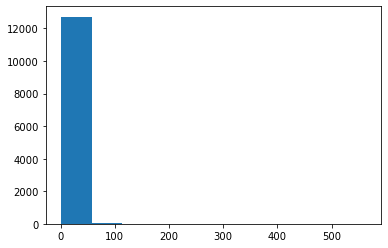

In [25]:
import matplotlib.pyplot as plt

plt.hist(list(wc.values()))

Text(0, 0.5, '# ocurrencias (log)')

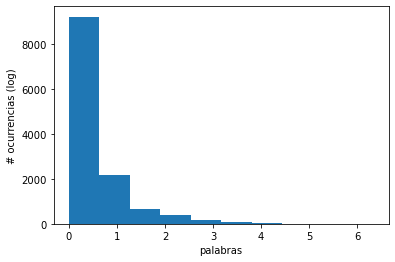

In [26]:
plt.hist(np.log(list(wc.values())))
plt.xlabel('palabras')
plt.ylabel('# ocurrencias (log)')

# Red Neuronal MultiCapa

In [27]:
tf.keras.backend.clear_session()

In [29]:
np.sqrt(np.sqrt(2000))

6.68740304976422

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

model = Sequential()
model.add(Embedding(input_dim=2000, 
                           output_dim=7, 
                           input_length=max_len))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dropout(.25))
model.add(Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=1e-4,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 82, 7)             14000     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 7)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 14,289
Trainable params: 14,289
Non-trainable params: 0
_________________________________________________________________



https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

In [48]:
batch_size = 32
history=model.fit(X_train,y_train.values,epochs=100,batch_size=batch_size,validation_data=(X_test, y_test.values),verbose=0)

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validacion')
    plt.title('Exactitud')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validacion')
    plt.title('Objetivo')
    plt.legend()

Exactitud Entrenamiento: 0.9124
Exactitud Testing:  0.6947


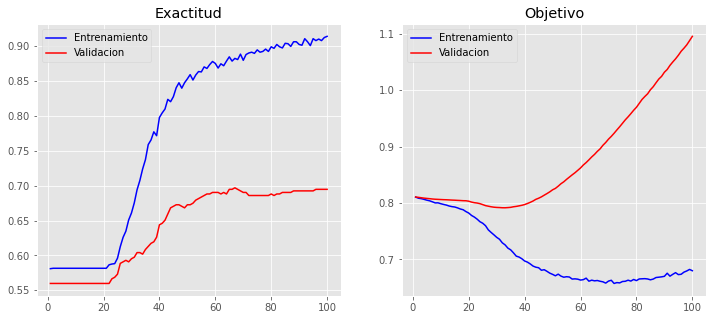

In [49]:
loss, accuracy = model.evaluate(X_train, y_train.values, verbose=False)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test.values, verbose=False)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

In [50]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test.values, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       199
           1       0.70      0.79      0.74       253

    accuracy                           0.69       452
   macro avg       0.69      0.68      0.68       452
weighted avg       0.69      0.69      0.69       452



In [98]:
model.save('hatespeech_embedding.h5')

In [99]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Red Neuronal Pre-Entrenada

In [52]:
!pip3 install tensorflow_hub

In [54]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-es-dim128/2",
    output_shape=[20], input_shape=[],
    dtype=tf.string, trainable=False
    )

In [56]:
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
outputs = hub_layer(inputs)
preprocessor = tf.keras.Model(inputs=inputs, outputs=outputs)

In [67]:
tf.keras.backend.clear_session()

In [92]:

from tensorflow.keras.layers import GlobalMaxPool2D

model = tf.keras.Sequential()
model.add(preprocessor)
model.add(Dense(64, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dropout(.25))
model.add(tf.keras.layers.Dense(32,activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dropout(.25))
model.add(tf.keras.layers.Dense(1))


In [93]:
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 128)               125009920 
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 125,020,289
Trainable params: 10,369
Non-trainable params: 125,009,920
___________________________________

In [63]:
df['labels']=labels
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)



In [94]:
train_text=train['data'].tolist()
train_labels=train['labels'].tolist()
test_text=test['data'].tolist()
test_labels=test['labels'].tolist()



In [98]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-5,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)
history = model.fit(train_text,train_labels,batch_size=32,
                    epochs=100,validation_data=(test_text, test_labels),verbose=0)

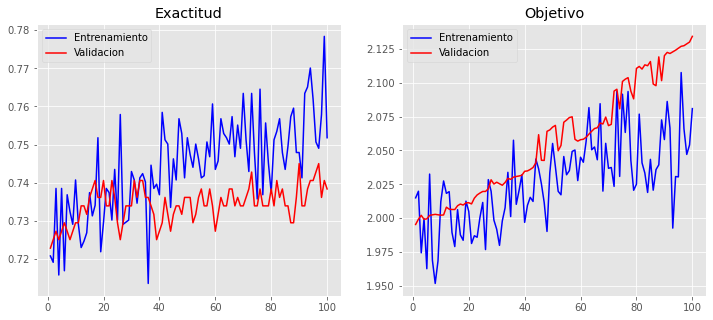

In [99]:
plot_history(history)

In [100]:
y_pred = model.predict(test_text)

print(classification_report(np.asarray(test_labels),y_pred.reshape(-1)>0.5))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       186
           1       0.76      0.81      0.78       265

    accuracy                           0.74       451
   macro avg       0.73      0.72      0.73       451
weighted avg       0.74      0.74      0.74       451



In [88]:
y_pred.reshape(-1).shape

(451,)

In [89]:
np.asarray(test_labels).shape

(451,)